In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.applications import (
    ResNet50, ResNet101, NASNetMobile, EfficientNetV2B0,
    DenseNet121, InceptionV3, Xception, MobileNetV2, VGG16, ResNet152V2
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

2025-05-26 19:00:47.562917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-26 19:00:47.562987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-26 19:00:47.564068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 19:00:47.571114: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
models = [
    ('VGG16', VGG16),
    ('ResNet50', ResNet50),
    ('ResNet152V2', ResNet152V2),
    ('NASNetMobile', NASNetMobile),
    ('EfficientNetV2B0', EfficientNetV2B0),
    ('MobileNetV2', MobileNetV2),
    ('DenseNet121', DenseNet121),
    ('InceptionV3', InceptionV3),
    ('Xception', Xception),
    ('ResNet101', ResNet101),
    

]

In [2]:
(x_train_full, y_train_full), (x_test_full, y_test_full) = tf.keras.datasets.cifar100.load_data(label_mode='fine')
selected_classes = list(range(20))
num_classes = len(selected_classes)

In [ ]:
def display_img(img_set, title_set):
  n = len(title_set)
  plt.figure(figsize=(10, 6))
  for i in range(n):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img_set[i], cmap = 'gray')
    plt.title(title_set[i])
  plt.tight_layout()
  plt.show()
  plt.close()




In [ ]:
train_mask = np.isin(y_train_full, selected_classes).flatten()
x_train = x_train_full[train_mask]
y_train = y_train_full[train_mask]

In [ ]:
test_mask = np.isin(y_test_full, selected_classes).flatten()
x_test = x_test_full[test_mask]
y_test = y_test_full[test_mask]

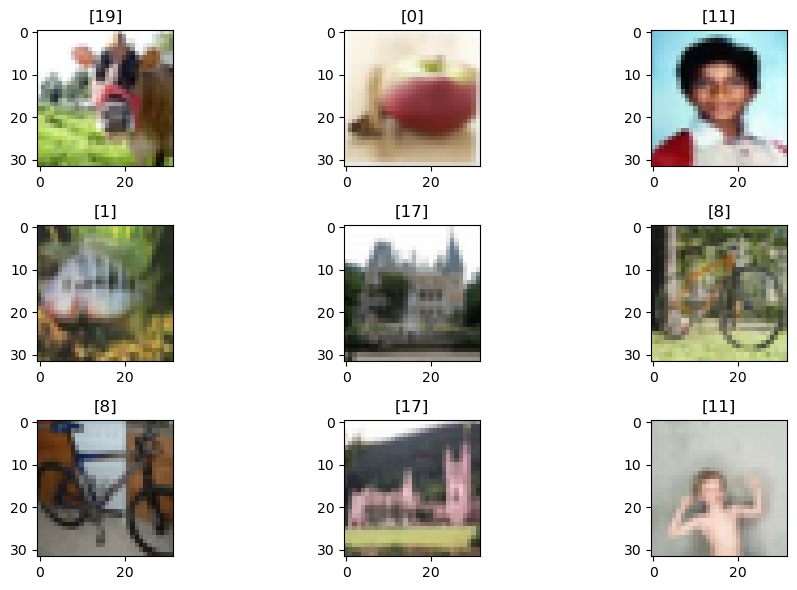

In [5]:
display_img(x_train[:9], y_train[:9])

In [6]:
label_mapping = {original: new for new, original in enumerate(selected_classes)}
y_train = np.vectorize(label_mapping.get)(y_train)
y_test = np.vectorize(label_mapping.get)(y_test)

print(y_test[0])


[15]


In [7]:
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


In [9]:

def preprocess_image(image, label, model_name, training=False):
    if model_name in ['InceptionV3', 'Xception']:
        image = tf.image.resize(image, (299, 299))
    else:
        image = tf.image.resize(image, (224, 224))

    if training:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    if model_name in ['InceptionV3', 'Xception']:
        image = tf.keras.applications.inception_v3.preprocess_input(image)
    elif model_name == 'EfficientNetV2B0':
        image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
    elif model_name == 'NASNetMobile':
        image = tf.keras.applications.nasnet.preprocess_input(image)
    elif model_name == 'MobileNetV2':
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    elif model_name == 'DenseNet121':
        image = tf.keras.applications.densenet.preprocess_input(image)
    elif model_name == 'VGG16':
         image = tf.keras.applications.vgg16.preprocess_input(image)
    elif model_name == 'ResNet152V2':
         image = tf.keras.applications.resnet_v2.preprocess_input(image)
    else:
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label


In [10]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))


2025-05-26 19:00:51.609501: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-26 19:00:51.670326: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-26 19:00:51.670539: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
activation_functions = ["softmax", "relu", "tanh", "sigmoid"]
results = []
start_time = time.time()

for model_name, ModelClass in models:
    for activation_fn in activation_functions:
        print(f"\nTraining {model_name} with {activation_fn} activation...")

        train_ds = train_dataset.map(lambda image, label: preprocess_image(image, label, model_name, training=True))
        train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=1)
        test_ds = test_dataset.map(lambda image, label: preprocess_image(image, label, model_name, training=False))
        test_ds = test_ds.batch(batch_size=32).prefetch(buffer_size=1)

        input_shape = (299, 299, 3) if model_name in ['InceptionV3', 'Xception'] else (224, 224, 3)
        base_model = ModelClass(weights='imagenet', include_top=False, input_shape=input_shape)
        base_model.trainable = False

        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)

        out = Dense(num_classes, activation=activation_fn, dtype='float32')(x)
        model = Model(inputs=base_model.input, outputs=out)
        model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(train_ds, epochs=5, validation_data=test_ds, verbose=1)
        test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
        results.append((model_name, activation_fn, test_accuracy, test_loss))


Training ResNet50 with softmax activation...
Epoch 1/5
Epoch 1/5


2025-05-26 19:00:59.951851: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-05-26 19:01:03.925503: I external/local_xla/xla/service/service.cc:168] XLA service 0x7e2368cbf870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-26 19:01:03.925532: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2025-05-26 19:01:03.932788: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748264464.014458   18306 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-05-26 19:01:03.925503: I external/local_xla/xla/service/service.cc:168] XLA service 0x7e2368cbf870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025

313/313 [==============================] - 54s 141ms/step - loss: 0.7653 - accuracy: 0.7696 - val_loss: 0.5062 - val_accuracy: 0.8380
Epoch 2/5
313/313 [==============================] - 51s 153ms/step - loss: 0.4159 - accuracy: 0.8621 - val_loss: 0.4561 - val_accuracy: 0.8585
Epoch 3/5
313/313 [==============================] - 49s 148ms/step - loss: 0.3577 - accuracy: 0.8811 - val_loss: 0.4956 - val_accuracy: 0.8525
Epoch 4/5
313/313 [==============================] - 45s 135ms/step - loss: 0.2745 - accuracy: 0.9059 - val_loss: 0.4712 - val_accuracy: 0.8595
Epoch 5/5
313/313 [==============================] - 52s 159ms/step - loss: 0.2520 - accuracy: 0.9112 - val_loss: 0.5295 - val_accuracy: 0.8510

Training ResNet50 with relu activation...
Epoch 1/5
313/313 [==============================] - 53s 148ms/step - loss: nan - accuracy: 0.0628 - val_loss: nan - val_accuracy: 0.0500
Epoch 2/5
313/313 [==============================] - 49s 148ms/step - loss: nan - accuracy: 0.0500 - val_loss

2025-05-26 19:33:29.743701: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 [==============================] - 31s 77ms/step - loss: 0.6282 - accuracy: 0.7994 - val_loss: 0.4470 - val_accuracy: 0.8570
Epoch 2/5
313/313 [==============================] - 22s 66ms/step - loss: 0.3808 - accuracy: 0.8714 - val_loss: 0.3946 - val_accuracy: 0.8765
Epoch 3/5
313/313 [==============================] - 21s 65ms/step - loss: 0.3024 - accuracy: 0.8969 - val_loss: 0.3984 - val_accuracy: 0.8715
Epoch 4/5
313/313 [==============================] - 21s 65ms/step - loss: 0.2563 - accuracy: 0.9116 - val_loss: 0.4525 - val_accuracy: 0.8715
Epoch 5/5
313/313 [==============================] - 22s 66ms/step - loss: 0.2127 - accuracy: 0.9270 - val_loss: 0.4282 - val_accuracy: 0.8840

Training EfficientNetV2B0 with relu activation...
Epoch 1/5


2025-05-26 19:35:31.449600: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 [==============================] - 28s 69ms/step - loss: nan - accuracy: 0.0837 - val_loss: nan - val_accuracy: 0.0500
Epoch 2/5
313/313 [==============================] - 21s 65ms/step - loss: nan - accuracy: 0.0500 - val_loss: nan - val_accuracy: 0.0500
Epoch 3/5
313/313 [==============================] - 21s 65ms/step - loss: nan - accuracy: 0.0500 - val_loss: nan - val_accuracy: 0.0500
Epoch 4/5
313/313 [==============================] - 21s 65ms/step - loss: nan - accuracy: 0.0500 - val_loss: nan - val_accuracy: 0.0500
Epoch 5/5
313/313 [==============================] - 21s 66ms/step - loss: nan - accuracy: 0.0500 - val_loss: nan - val_accuracy: 0.0500

Training EfficientNetV2B0 with tanh activation...
Epoch 1/5


2025-05-26 19:37:30.244050: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 [==============================] - 28s 69ms/step - loss: nan - accuracy: 0.0560 - val_loss: nan - val_accuracy: 0.0500
Epoch 2/5
313/313 [==============================] - 21s 65ms/step - loss: nan - accuracy: 0.0500 - val_loss: nan - val_accuracy: 0.0500
Epoch 3/5
313/313 [==============================] - 21s 65ms/step - loss: nan - accuracy: 0.0500 - val_loss: nan - val_accuracy: 0.0500
Epoch 4/5
313/313 [==============================] - 21s 65ms/step - loss: nan - accuracy: 0.0500 - val_loss: nan - val_accuracy: 0.0500
Epoch 5/5
313/313 [==============================] - 21s 65ms/step - loss: nan - accuracy: 0.0500 - val_loss: nan - val_accuracy: 0.0500

Training EfficientNetV2B0 with sigmoid activation...
Epoch 1/5


2025-05-26 19:39:28.214377: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 [==============================] - 28s 70ms/step - loss: 0.6342 - accuracy: 0.7972 - val_loss: 0.4016 - val_accuracy: 0.8720
Epoch 2/5
313/313 [==============================] - 22s 66ms/step - loss: 0.3745 - accuracy: 0.8754 - val_loss: 0.4106 - val_accuracy: 0.8735
Epoch 3/5
313/313 [==============================] - 22s 66ms/step - loss: 0.2938 - accuracy: 0.9027 - val_loss: 0.4011 - val_accuracy: 0.8750
Epoch 4/5
313/313 [==============================] - 22s 66ms/step - loss: 0.2519 - accuracy: 0.9111 - val_loss: 0.4251 - val_accuracy: 0.8770
Epoch 5/5
313/313 [==============================] - 22s 66ms/step - loss: 0.2196 - accuracy: 0.9250 - val_loss: 0.4556 - val_accuracy: 0.8765

Training MobileNetV2 with softmax activation...
Epoch 1/5
313/313 [==============================] - 22s 58ms/step - loss: 0.9591 - accuracy: 0.7047 - val_loss: 0.6730 - val_accuracy: 0.7775
Epoch 2/5
313/313 [==============================] - 18s 54ms/step - loss: 0.6215 - accuracy: 0.7957 - 

2025-05-26 20:00:20.101607: W external/local_tsl/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


313/313 [==============================] - 53s 140ms/step - loss: 0.9505 - accuracy: 0.7171 - val_loss: 0.6553 - val_accuracy: 0.7975
Epoch 2/5
313/313 [==============================] - 43s 131ms/step - loss: 0.5917 - accuracy: 0.8056 - val_loss: 0.6213 - val_accuracy: 0.8035
Epoch 3/5
313/313 [==============================] - 43s 131ms/step - loss: 0.4942 - accuracy: 0.8335 - val_loss: 0.5626 - val_accuracy: 0.8275
Epoch 4/5
313/313 [==============================] - 44s 135ms/step - loss: 0.4433 - accuracy: 0.8540 - val_loss: 0.6390 - val_accuracy: 0.8030
Epoch 5/5
313/313 [==============================] - 43s 132ms/step - loss: 0.4228 - accuracy: 0.8559 - val_loss: 0.6188 - val_accuracy: 0.8205

Training InceptionV3 with relu activation...
Epoch 1/5
313/313 [==============================] - 47s 134ms/step - loss: nan - accuracy: 0.0737 - val_loss: nan - val_accuracy: 0.0500
Epoch 2/5
313/313 [==============================] - 43s 132ms/step - loss: nan - accuracy: 0.0500 - val_l

2025-05-26 20:15:46.316865: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-26 20:15:46.466651: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-26 20:15:47.157314: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-26 20:15:47.271628: W external/local_tsl/tsl/framework/bfc_

313/313 [==============================] - 93s 271ms/step - loss: 0.7397 - accuracy: 0.7714 - val_loss: 0.5324 - val_accuracy: 0.8355
Epoch 2/5
313/313 [==============================] - 83s 258ms/step - loss: 0.4427 - accuracy: 0.8526 - val_loss: 0.5497 - val_accuracy: 0.8205
Epoch 3/5
313/313 [==============================] - 85s 266ms/step - loss: 0.3542 - accuracy: 0.8791 - val_loss: 0.5000 - val_accuracy: 0.8435
Epoch 4/5
313/313 [==============================] - 83s 260ms/step - loss: 0.2833 - accuracy: 0.9026 - val_loss: 0.5888 - val_accuracy: 0.8305
Epoch 5/5
313/313 [==============================] - 82s 257ms/step - loss: 0.2225 - accuracy: 0.9233 - val_loss: 0.5708 - val_accuracy: 0.8420

Training Xception with relu activation...
Epoch 1/5
313/313 [==============================] - 87s 267ms/step - loss: nan - accuracy: 0.0656 - val_loss: nan - val_accuracy: 0.0500
Epoch 2/5
313/313 [==============================] - 87s 272ms/step - loss: nan - accuracy: 0.0500 - val_loss

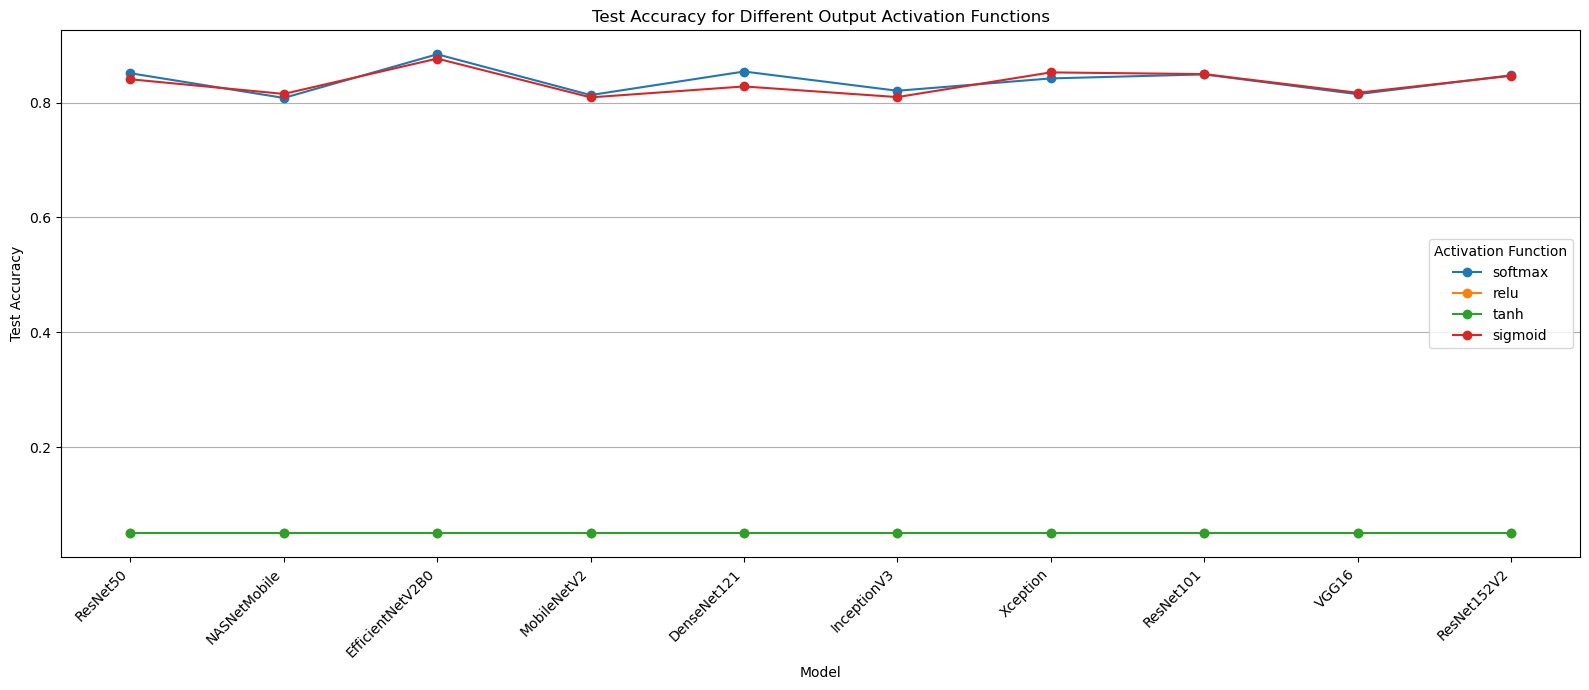

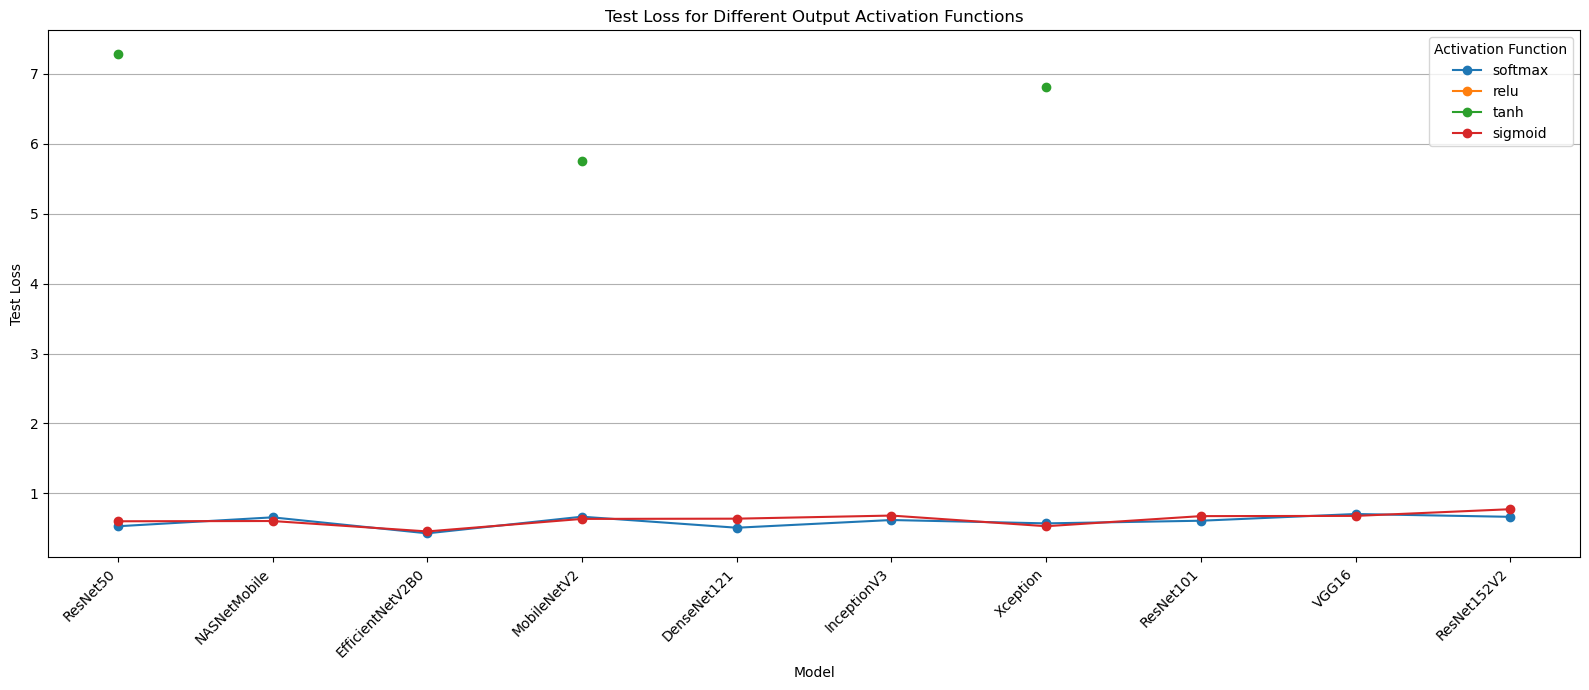

In [12]:
import pandas as pd

# Prepare results for visualization
results_df = pd.DataFrame(results, columns=["Model", "Activation", "Accuracy", "Loss"])

plt.figure(figsize=(16, 7))
for activation in activation_functions:
    subset = results_df[results_df["Activation"] == activation]
    plt.plot(subset["Model"], subset["Accuracy"], marker='o', label=f"{activation}")
plt.title('Test Accuracy for Different Output Activation Functions')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45, ha='right')
plt.legend(title="Activation Function")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(16, 7))
for activation in activation_functions:
    subset = results_df[results_df["Activation"] == activation]
    plt.plot(subset["Model"], subset["Loss"], marker='o', label=f"{activation}")
plt.title('Test Loss for Different Output Activation Functions')
plt.xlabel('Model')
plt.ylabel('Test Loss')
plt.xticks(rotation=45, ha='right')
plt.legend(title="Activation Function")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
plt.close()
